# Oil spills in New York State

Author: Carmen Galaz García

Repository: https://github.com/carmengg/eds220-oil-spills-sample-repo

## About

In this notebook we create a [choropleth map](https://en.wikipedia.org/wiki/Choropleth_map) showing the number of oil spills per county in the state of New York from January to October 2023. 


### Highlights
- Data wrangling and exploration of with `pandas`
- Geospatial data wrangling with `geopandas`
- Merging of tabular and vector data
- Creating and customizing a choropleth map


## About the data
In this notebook we use two datasets:


**1) Spill incidents in NY state**

The first dataset contains information about [spilling incidents of petroleum and other hazardous materials in the state of New York, US.](https://data.ny.gov/Energy-Environment/Spill-Incidents/u44d-k5fk). 
According to the New York State Department of Environmental Conservation, around 15,000 spill reports are recorded each year, with around 90% of these spills related to petroleum products. 

This dataset has been downloaded from the New York State data portal as a csv file. 
It has 20 columns recording information about the location, time, source, and materials involved in each spill. 
For this analysis we will use the following columns:

- **Material Family**: represents the family of the spilled material: Petroleum, Oxygenates, Hazardous Material, Other.
- **Spill Date**: Date of spill.
- **County**: County location of the spill.

Additional information and metadata for this datset is available in the 'NYSDEC_SpillIncidents_Overview.pdf' and 'NYSDEC_SpillIncidents_DataDictionary.pdf' located at the portal.

**2) Natural Earth 1:10m Cultural Vectors, Counties**

The second dataset is [Natural Earth's United States Counties at 1:10m resolution](https://www.naturalearthdata.com/downloads/10m-cultural-vectors/). 
This dataset has been downloaded as a shapefile from Natural Earth's data portal. 
It has 62 columns with information about the counties name and location within the US. 

## Import libraries

In [38]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
from matplotlib.patches import Patch

In [34]:
# set pandas to display all columns
pd.set_option('display.max_columns', None)

## Import data 

In [24]:
# import dataset from data repository
#spills = pd.read_csv('https://data.ny.gov/resource/u44d-k5fk.csv')

# import datasets from data directory
data_dir = os.path.join(os.getcwd(), 'data')

spills = pd.read_csv(os.path.join(data_dir,'Spill_Incidents.csv'))
counties = gpd.read_file(os.path.join(data_dir,'ne_10m_admin_2_counties','ne_10m_admin_2_counties.shp'))

## Prepare spills data

First, we can take a quick look at our `spills` dataframe:

In [27]:
# update column names to small caps and replace spaces with _
print('old column names:\n', spills.columns, '\n')
spills.columns = spills.columns.str.lower().str.replace(' ','_')

# check first three rows of dataframe
spills.head(3)

old column names:
 Index(['spill_number', 'program_facility_name', 'street_1', 'street_2',
       'locality', 'county', 'zip_code', 'swis_code', 'dec_region',
       'spill_date', 'received_date', 'contributing_factor', 'waterbody',
       'source', 'close_date', 'material_name', 'material_family', 'quantity',
       'units', 'recovered'],
      dtype='object') 



,spill_number,program_facility_name,street_1,street_2,locality,county,zip_code,swis_code,dec_region,spill_date,received_date,contributing_factor,waterbody,source,close_date,material_name,material_family,quantity,units,recovered
0,107132,MH 864,RT 119/MILLWOOD RD,NaN,ELMSFORD,Westchester,NaN,6000,3,10/10/2001,10/10/2001,Unknown,NaN,Unknown,10/15/2001,unknown material,Other,10.0,Gallons,0.0
1,405586,BOWRY BAY,WATER POLL CONTROL,NaN,QUEENS,Queens,NaN,4101,2,08/21/2004,08/21/2004,Other,EAST RIVER,Unknown,09/17/2004,raw sewage,Other,0.0,Pounds,0.0
2,405586,BOWRY BAY,WATER POLL CONTROL,NaN,QUEENS,Queens,NaN,4101,2,08/21/2004,08/21/2004,Other,EAST RIVER,Unknown,09/17/2004,raw sewage,Other,0.0,NaN,0.0


Since we will subset the data by date, we'll update the data type of the the `spill_date` column to datetime type:

In [28]:
print('original dtype of spill_date: ', type(spills.dtypes.spill_date))
      
# convert spill_date to datetime dtype
spills.spill_date = pd.to_datetime(spills.spill_date)
      
print('updated dtype of spill_date: ', type(spills.dtypes.spill_date))

original dtype of spill_date:  <class 'numpy.dtype[object_]'>
updated dtype of spill_date:  <class 'numpy.dtype[datetime64]'>


### Data selection

As the next cell shows, there are multiple material families in the spills dataset and spills record go back to 1900. 
For this analysis, we select data about petroleum spills that took place between January 1st 2023 and October 31st  2023 (including both dates). 

In [29]:
# material families in spills
print('spills materials: ', spills.material_family.unique())

# oldest spill record
print('oldes spill record: ', spills.spill_date.dt.year.min())

spills materials:  ['Other' 'Petroleum' 'Hazardous Material' 'Oxygenates']
oldes spill record:  1900.0


In [33]:
# select petroleum spills from January to October 2023
petr_23 = spills[ (spills.spill_date >= '2023-01-01') & (spills.spill_date<='2023-10-31') & (spills.material_family == 'Petroleum')].copy()

# verify data selection
print('AFTER DATA SELECTION')
print(f"material family: {petr_23.material_family.unique()}")
print(f'year: {petr_23.spill_date.dt.year.unique()}')
print(f'months: {petr_23.spill_date.dt.month.unique()}')

AFTER DATA SELECTION: 
material family: ['Petroleum']
year: [2023]
months: [ 6  8  9  7  1  2  3 10  5  4]


### Data aggregation

In this step we create new dataframe named `spills_per_county` with the number of petroleum spills per county from January to October 2023:

In [31]:
# obtain number of spills per county as dataframe
spills_per_county = pd.DataFrame(petr_23.groupby('county').count().spill_number)
spills_per_county = spills_per_county.rename(columns={'spill_number':'n_spills'}).reset_index()
spills_per_county

,county,n_spills
0,Albany,204
1,Allegany,30
2,Bronx,143
3,Broome,74
4,Cattaraugus,46
...,...,...
59,Washington,96
60,Wayne,38
61,Westchester,730
62,Wyoming,24


## Prepare counties data

First, we can take a quick look at our GeoDataFrame:

In [36]:
# update column names to small caps
print('old column names:\n', counties.columns, '\n')
counties.columns = counties.columns.str.lower()

# check first three rows of geodataframe
counties.head(3)

old column names:
 Index(['featurecla', 'scalerank', 'adm2_code', 'iso_3166_2', 'iso_a2',
       'adm0_sr', 'name', 'name_alt', 'name_local', 'type', 'type_en',
       'code_local', 'region', 'region_cod', 'abbrev', 'area_sqkm',
       'sameascity', 'labelrank', 'name_len', 'mapcolor9', 'mapcolor13',
       'fips', 'sov_a3', 'adm0_a3', 'adm0_label', 'admin', 'geonunit', 'gu_a3',
       'min_label', 'max_label', 'min_zoom', 'wikidataid', 'ne_id', 'latitude',
       'longitude', 'name_ar', 'name_bn', 'name_de', 'name_el', 'name_en',
       'name_es', 'name_fa', 'name_fr', 'name_he', 'name_hi', 'name_hu',
       'name_id', 'name_it', 'name_ja', 'name_ko', 'name_nl', 'name_pl',
       'name_pt', 'name_ru', 'name_sv', 'name_tr', 'name_uk', 'name_ur',
       'name_vi', 'name_zh', 'name_zht', 'geometry'],
      dtype='object') 



,featurecla,scalerank,adm2_code,iso_3166_2,iso_a2,adm0_sr,name,name_alt,name_local,type,type_en,code_local,region,region_cod,abbrev,area_sqkm,sameascity,labelrank,name_len,mapcolor9,mapcolor13,fips,sov_a3,adm0_a3,adm0_label,admin,geonunit,gu_a3,min_label,max_label,min_zoom,wikidataid,ne_id,latitude,longitude,name_ar,name_bn,name_de,name_el,name_en,name_es,name_fa,name_fr,name_he,name_hi,name_hu,name_id,name_it,name_ja,name_ko,name_nl,name_pl,name_pt,name_ru,name_sv,name_tr,name_uk,name_ur,name_vi,name_zh,name_zht,geometry
0,Admin-2 scale rank,0,USA-53073,US-53,US,1,Whatcom,Whatcom County,None,County,County,53073,WA,53,None,5484.0,0,0,7,1,1,US53073,US1,USA,2,United States of America,United States of America,USA,7,9,6.5,Q156623,1730095903,48.817814,-121.709219,واتكوم,None,Whatcom,None,Whatcom,Whatcom,شهرستان واتکام، واشینگتن,Whatcom,מחוז ואטקום,None,Whatcom,None,Whatcom,ワットコム郡,왓컴,Whatcom,Whatcom,Whatcom,Уотком,Whatcom,Whatcom,Вотком,واٹکم کاؤنٹی، واشنگٹن,Whatcom,霍特科姆县,霍特科姆縣,"MULTIPOLYGON (((-122.75302 48.99251, -122.6532..."
1,Admin-2 scale rank,0,USA-53047,US-53,US,1,Okanogan,Okanogan County,None,County,County,53047,WA,53,None,13704.0,0,0,8,1,1,US53047,US1,USA,2,United States of America,United States of America,USA,7,9,6.5,Q483958,1730095887,48.538853,-119.737274,أوكانوغان,None,Okanogan,None,Okanogan,Okanogan,شهرستان اوکانوگان، واشینگتن,'Okanogan,מחוז אוקאנוגאן,None,Okanogan,None,Okanogan,オウカノガン郡,오커나건,Okanogan,Okanogan,Okanogan,Оканоган,Okanogan,Okanogan,Оканоґан,اوکاناگن کاؤنٹی، واشنگٹن,Okanogan,奥卡诺根县,奧卡諾根縣,"POLYGON ((-120.85196 48.99251, -120.67495 48.9..."
2,Admin-2 scale rank,0,USA-53019,US-53,US,1,Ferry,Ferry County,None,County,County,53019,WA,53,None,5816.0,0,0,5,1,1,US53019,US1,USA,2,United States of America,United States of America,USA,7,9,6.5,Q493228,1730095865,48.462338,-118.524213,فيري,None,Ferry,None,Ferry,Ferry,شهرستان فری، واشینگتن,Ferry,מחוז פרי,None,Ferry,None,Ferry,フェリー郡,페리,Ferry,Ferry,Ferry,Ферри,Ferry,Ferry,Феррі,فیری کاؤنٹی، واشنگٹن,Ferry,费里县,費里縣,"POLYGON ((-118.83688 48.99251, -118.69668 48.9..."


### Data selection

In this step we select all the counties for the state of New York in a new variable `ny_counties` and plot them.

Text(0.5, 1.0, 'Counties in New York state')

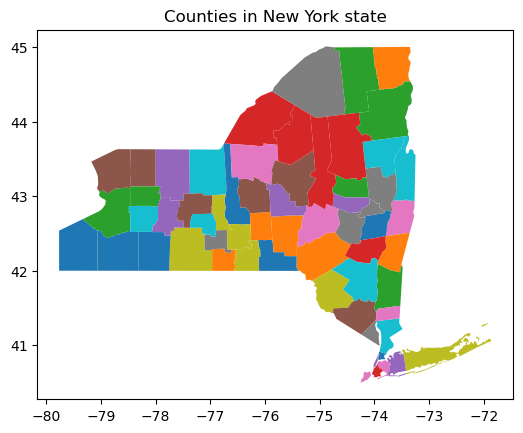

In [99]:
# select NY counties data
ny_counties = counties[counties.region == 'NY']

# --------------------------------------
# plot
fig, ax = plt.subplots()
ny_counties.plot(ax=ax, column='name')
ax.set_title('Counties in New York state')

### Geographic context

For context, let's see where NY state is relative to the United States mainland. 

In [70]:
# dissolve counties into multipolygon, then get individual polygons in multipolygon as rows
us_polys = counties.dissolve().explode(ignore_index=True)

# select US mainland polygon
us = us_polys.iloc[[0]]

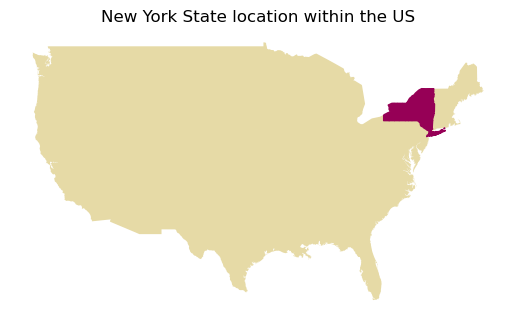

In [86]:
# PLOT OF NY STATE WITHIN THE US

fig, ax = plt.subplots()
ax.axis('off')
ax.set_title('New York state location within the US')

us.plot(ax=ax, color='#e6daa6',)
ny_counties.plot(ax=ax, color = '#960056', edgecolor='#960056')

plt.show()

## Merging

In this section we merge the `spills_per_county` and `ny_counties` dataframes into a single dataframe with the number of spills per county and the corresponding geometries for each county. 

### Preliminary exploration
Before doing the merge we verify the county names in both dataframes match and whether any data will be left out when merging.

In [97]:
# detect discrepancies between county names in `spills_per_county` and `ny_counties`
print('counties in spills_per_county, but not in ny_counties:\n', 
        np.setdiff1d(spills_per_county.county.unique(), ny_counties.name.unique()),'\n')
print('counties in ny_counties, but not in spills_per_county:\n',
        np.setdiff1d(ny_counties.name.unique(),spills_per_county.county.unique()))

counties in spills_per_county, but not in ny_counties:
 ['New Jersey - Region 2' 'St Lawrence' 'Tuscarora Indian Reservation'] 

counties in ny_counties, but not in spills_per_county:
 ['Saint Lawrence']


The following cells show there is 1 spill in Tuscarora Indian Reservation and 6 spills reported in New Jersey - Region 2. 

Tuscarora Indian Reservation is located within Niagara county, so we will add this spill to Niagara county in the next section. 

[According to the US Environmental Protection Agency](https://www.epa.gov/aboutepa/epa-region-2), Region 2 icnludes New Jersey, New Your, Puerto Rico, the U.S. Virgin Islands and eight Indian Nations. 
Since these spills are not associated to a specific county, we will not include them in the spills per county count. 

In [23]:
# check spills in 'Tuscarora Indian Reservation'
spills_per_county[spills_per_county.county == 'Tuscarora Indian Reservation']

,county,n_spills
56,Tuscarora Indian Reservation,1


In [90]:
# check spills in 'New Jersey - Region 2'
spills_per_county[spills_per_county.county == 'New Jersey - Region 2']

,county,n_spills
30,New Jersey - Region 2,6


### Data updates

In this section we will update 'St Lawrence' to 'St. Lawrence' in `spills_per_county` data frame.

In the next cells:
1. Check the row in `spills_per_county` that has 'St Lawrence'
2. Run the code and read the explanation in the comments
3. Run the code and read the explanation in the comments
4. Use the `st_lawrence_index` and `at` to update St Lawrence name in `spills_per_county` dataframe
5. Check the update was successfull

In [24]:
# 1. 
spills_per_county.loc[spills_per_county.county=='St Lawrence']

,county,n_spills
50,St Lawrence,65


In [25]:
# 2. we can get the index of that single row like this, to access the actual row index...
spills_per_county[spills_per_county.county=='St Lawrence'].index

Int64Index([50], dtype='int64')

In [26]:
# 3. we need to select the first item in that tuple using [0]
st_lawrence_index = spills_per_county[spills_per_county.county=='St Lawrence'].index[0]
st_lawrence_index

50

In [27]:
# 4. 
spills_per_county.at[st_lawrence_index, 'county'] = 'St. Lawrence'

In [28]:
# 5.
spills_per_county.loc[spills_per_county.county == 'St. Lawrence','county']

50    St. Lawrence
Name: county, dtype: object

### Merge

In the following cells:
1. Use this cell to make any other updates needed for making an inner join of the `spills_per_county` and `ny_counties`. 
2. Over-write `ny_counties` as the  inner join of the `spills_per_county` and `ny_counties` dataframes.

From our previous exploration we know that Tuscarora Indian Reservation will not be in the join. Tuscarora Indian Reservation is located within Niagara county. 

3. Since the Tuscarora Indian Reservation does not appear in the `ny_counties` dataframe, add one spill to Niagara county. We will add a note about this in our final map. You may add all the cells to make this update **and** verify that the dataframe was updated.

In [29]:
# 1. 
ny_counties = ny_counties.rename(columns={'name':'county'})


In [30]:
# join dataframes
ny_counties = pd.merge(ny_counties, spills_per_county, how='inner', on='county')
ny_counties.head()

,statefp,countyfp,countyns,geoid,county,namelsad,lsad,classfp,mtfcc,csafp,cbsafp,metdivfp,funcstat,aland,awater,intptlat,intptlon,geometry,n_spills
0,36,101,00974148,36101,Steuben,Steuben County,06,H1,G4020,None,None,None,A,3601398422,35039875,+42.2667252,-077.3855253,"POLYGON ((-77.08327 42.00002, -77.09391 41.999...",71
1,36,091,00974143,36091,Saratoga,Saratoga County,06,H1,G4020,None,None,None,A,2097812305,87488004,+43.1061353,-073.8553872,"POLYGON ((-73.67891 42.91221, -73.67938 42.911...",158
2,36,003,00974100,36003,Allegany,Allegany County,06,H1,G4020,None,None,None,A,2666225086,12989848,+42.2478532,-078.0261531,"POLYGON ((-78.04342 42.51846, -78.04326 42.518...",30
3,36,075,00974136,36075,Oswego,Oswego County,06,H1,G4020,None,None,None,A,2464636023,933469962,+43.4614431,-076.2092618,"POLYGON ((-76.02509 43.70702, -76.02004 43.706...",68
4,36,111,00974153,36111,Ulster,Ulster County,06,H1,G4020,None,None,None,A,2911757764,94596810,+41.9472124,-074.2654582,"POLYGON ((-74.07480 42.09659, -74.06441 42.120...",158


In [31]:
# check Niagara row
ny_counties.loc[ny_counties.county=='Niagara','n_spills']

45    88
Name: n_spills, dtype: int64

In [32]:
# find index and add one
niagara_index = ny_counties[ny_counties.county=='Niagara'].index[0]
ny_counties.at[niagara_index, 'n_spills']+=1
ny_counties.loc[ny_counties.county=='Niagara']


,statefp,countyfp,countyns,geoid,county,namelsad,lsad,classfp,mtfcc,csafp,cbsafp,metdivfp,funcstat,aland,awater,intptlat,intptlon,geometry,n_spills
45,36,063,00974130,36063,Niagara,Niagara County,06,H1,G4020,None,None,None,A,1352887560,1598842379,+43.2726719,-078.8129431,"POLYGON ((-78.49165 43.08396, -78.49179 43.084...",89


## Map
Create a choropleth map of the number of petroleum spills per county in the state of New York in 2023. 
Your map should have (at least) the following updates:
- a legend indicating the number of spills
- an updated color map
- a title 
- no axis
- an annotation with the data source (New York State Department of Environmental Conservation), date of access HINT: check the graph we did for power plants, 
- an annotation indicating one spill occurred in Tuscarora Indian Reservation within Niagara county

Tuscarora Indian Reservation in Niagara county

Text(0.05, 0.16, 'The oil spill rerpoted in Tuscarora Indian Reservation, was added to Niagara county.')

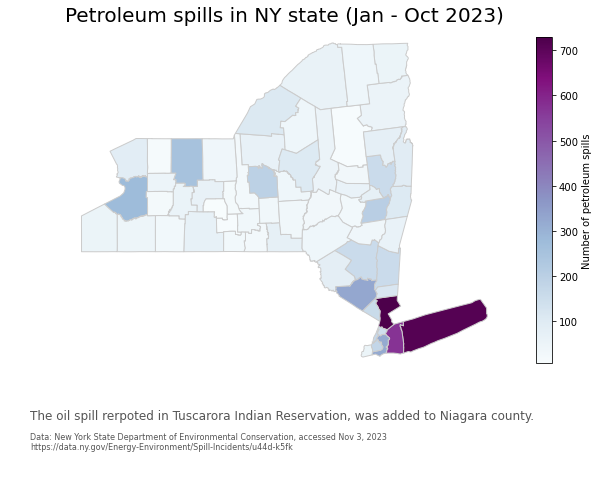

In [33]:
fig, ax = plt.subplots(figsize=(10,10))

ax.axis('off')
ax.set_title('Petroleum spills in NY state (Jan - Oct 2023)',  fontsize=20)

ny_counties.plot(ax=ax, 
                column='n_spills', 
                cmap='BuPu',
                legend=True,
                edgecolor="0.8",
                legend_kwds={"shrink":.6,
                             'label': "Number of petroleum spills"})

# annotate the data source
ax.annotate("Data: New York State Department of Environmental Conservation, accessed Nov 3, 2023 \nhttps://data.ny.gov/Energy-Environment/Spill-Incidents/u44d-k5fk", 
            xy=(0.05, .1), # position
            xycoords='figure fraction', 
            fontsize=8, 
            color='#555555') 

# annotate Tuscarora
ax.annotate("The oil spill rerpoted in Tuscarora Indian Reservation, was added to Niagara county.", 
            xy=(0.05, .16), # position
            xycoords='figure fraction', 
            fontsize=12, 
            color='#555555') 


plt.show()